In [1]:
# imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import utils
import SIREN_utils
import json
from torch.utils.data import DataLoader
import os
import h5py
import math
import random
import scienceplots

from SIREN_utils import (
    extract_diagonals,
    fold_OP_mat,
    matrix_processing,
    plot_complex_matrix,
    get_interpolated_matrix,
    Siren,
    check_D4_symmetries,
    apply_periodic_boundary_conditions,
    enforce_D4_symmetries_pytorch,
    get_normalized_coords,
    run_model_inference,
    print_comparison,
    reformat_matrix_from_diagonals,
    unfold_OP_mat
)

In [2]:
plt.style.use(["science", "notebook", "grid"])

### Technical Stuff (Engineering)

In [3]:
import sys

# Set the cache size limit to the largest possible integer
torch._dynamo.config.cache_size_limit = sys.maxsize

print(f"torch._dynamo.config.cache_size_limit is now set to: {torch._dynamo.config.cache_size_limit}")

torch._dynamo.config.cache_size_limit is now set to: 9223372036854775807


In [4]:
torch.set_float32_matmul_precision('highest')

In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Using device: cuda



### Running training script

In [3]:
# state variables
U = 1
error_c='2e-5'
label = f"U_{U}_ground_state"

In [7]:
# for lr scheduler
MAX_LR = 1e-3
MAX_NUM_EPOCHS = 5_00   # 500 initially, then 5000
NUM_WARMUP_EPOCHS = 20


def training_script(num_freqs: int, index: int = 0, device = device):
    # Set random seed for reproducibility
    torch.manual_seed(index)
    np.random.seed(index)
    random.seed(index)

    # number of frequencies
    NUM_FREQS = num_freqs

    # make a new folder for this test
    folder_name = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_{U}_ground_state/{NUM_FREQS}_test_index_{index}"

    # dataset files
    TRAIN_DATASET1 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_8x8_U_{U}_ground_state.h5"
    TRAIN_DATASET2 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_10x10_U_{U}_ground_state.h5"
    VAL_DATASET = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_18x18_U_{U}_ground_state.h5"

    filenames_dict = {
        TRAIN_DATASET1: 467,
        TRAIN_DATASET2: 1001,
    }
    chunks_8 = 20
    chunks_10 = 43

    # get normalization constants
    stats = utils.get_normalization_constants_3x3(filenames_dict, write_to=f"normalization_constants.json")

    print("Normalization Constants:")
    print(stats)

    # Check if CUDA is available, otherwise use CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    dims = [8, 10, 18]    # could go (for example) from 8 to 18 in increments of 2
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    with h5py.File(TRAIN_DATASET1, 'r') as f:
        io_dim = f['dataset'].shape[-1]

    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = io_dim,
        embed_dim = 64,
        output_dim = io_dim,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    try:
        os.mkdir(folder_name)
        print(f"Folder '{folder_name}' created successfully.\n")
    except FileExistsError:
        print(f"Folder '{folder_name}' already exists.\n")

        # Load the saved state_dict
        print(f"Loading model from {folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth")
        state_dict = torch.load(f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth")

        # Create a new state_dict without the prefix
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('_orig_mod.'):
                name = k[10:] # remove `_orig_mod.`
                new_state_dict[name] = v
            else:
                new_state_dict[k] = v

        # Load the corrected state_dict
        model.load_state_dict(new_state_dict)
        
    except OSError as e:
        print(f"Error creating folder: {e}\n")
    
    # compile the model
    model = torch.compile(model, mode="max-autotune", fullgraph=True)

    # make training and validation datasets
    training_data1 = utils.HF_3x3_Dataset(TRAIN_DATASET1, stats)
    print(f"Training dataset length: {training_data1.__len__()}\n")

    training_data2 = utils.HF_3x3_Dataset(TRAIN_DATASET2, stats)
    print(f"Training dataset length: {training_data2.__len__()}\n")

    validation_data = utils.HF_3x3_Dataset(VAL_DATASET, stats)
    print(f"Test dataset length: {validation_data.__len__()}\n")

    # training and test dataloaders
    train_dataloader1 = DataLoader(training_data1, chunks_8, shuffle=True, pin_memory=True, num_workers=1)
    train_dataloader2 = DataLoader(training_data2, chunks_10, shuffle=True, pin_memory=True, num_workers=1)
    val_dataloader = DataLoader(validation_data, 4, shuffle=True, pin_memory=True, num_workers=1)

    # Loss function and optimizer
    loss_fn = torch.nn.MSELoss(reduction = "sum")
    optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR)

    # Define schedulers
    min_lr = 1e-7
    k = min_lr / MAX_LR
    linear_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=k, end_factor=1.0, total_iters=NUM_WARMUP_EPOCHS)

    cosine_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (MAX_NUM_EPOCHS - NUM_WARMUP_EPOCHS))

    # Combine them
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[linear_warmup, cosine_annealing],
        milestones=[NUM_WARMUP_EPOCHS]
    )


    train_losses = []
    val_losses = []

    # train the model and record the loss for the training and validation datasets
    for t in range(MAX_NUM_EPOCHS):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_losses.append(
            utils.train_loop([train_dataloader1, train_dataloader2], model, loss_fn, optimizer, scheduler, device)
        )
        val_losses.append(utils.test_loop([val_dataloader], model, loss_fn, device))
        # save the model occasionally
        if (t % 100 == 0):
            print("Saving model...")
            torch.save(
                model.state_dict(),
                f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{t + 1}.pth",
            )
            print("Model saved!\n")
    print("Done!\n")

    print(f"Training Losses (1-{MAX_NUM_EPOCHS}): {train_losses}")
    print(f"Test Losses (1-{MAX_NUM_EPOCHS}): {val_losses}\n")

    utils.plot_losses(train_losses, val_losses, img_filename=f"{folder_name}/train_test_losses.png")

    # saving model
    torch.save(
        model.state_dict(),
        f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth",
    )

    return min(val_losses)

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/32_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------


/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W1025 22:17:22.108000 3501803 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(1280x128, 1280x64, 64x128)
  bias_addmm 0.0136 ms 100.0% 
  addmm 0.0164 ms 83.2% 
SingleProcess AUTOTUNE benchmarking takes 0.2611 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(1280x4, 1280x64, 64x4)
  bias_addmm 0.0123 ms 100.0% 
  addmm 0.0146 ms 84.4% 
SingleProcess AUTOTUNE benchmarking takes 0.0907 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(4300x128, 4300x64, 64x128)
  bias_addmm 0.0245 ms 100.0% 
  addmm 0.0287 ms 85.6% 
SingleProcess AUTOTUNE benchmarking takes 0.0885 seconds and 0.0001 second

Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015808


AUTOTUNE addmm(1296x64, 1296x4, 4x64)
  bias_addmm 0.0123 ms 100.0% 
  addmm 0.0133 ms 92.3% 
SingleProcess AUTOTUNE benchmarking takes 0.0890 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(1296x4, 1296x64, 64x4)
  bias_addmm 0.0123 ms 100.0% 
  addmm 0.0133 ms 92.3% 
SingleProcess AUTOTUNE benchmarking takes 0.0834 seconds and 0.0001 seconds precompiling for 2 choices


Avg Test loss: 0.960800 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.010176
Avg Test loss: 0.955779 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 1.004967
Avg Test loss: 0.952045 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 1.002823
Avg Test loss: 0.951017 

Epoch 5
-------------------------------
Current Learning Rate: 0.000250075
Train loss: 1.001626
Avg Test loss: 0.950711 

Epoch 6
-------------------------------
Current Learning Rate: 0.00030007
Train loss: 1.001425
Avg Test loss: 0.950451 

Epoch 7
-------------------------------
Current Learning Rate: 0.000350065
Train loss: 1.000939
Avg Test loss: 0.950141 

Epoch 8
-------------------------------
Current Learning Rate: 0.00040006000000000004
Train loss: 1.000766
Avg Test loss: 0.950068 

Epoch 9
-------------------------------
Current Learning Rate: 0.00045

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949609 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000046
Avg Test loss: 0.950017 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 1.000015
Avg Test loss: 0.949764 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.999992
Avg Test loss: 0.949727 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 1.000010
Avg Test loss: 0.949537 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000018
Avg Test loss: 0.949403 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000060
Avg Test loss: 0.949668 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000034
Avg Test loss: 0.949609 

Epoch 28
-------------------------------
Cur

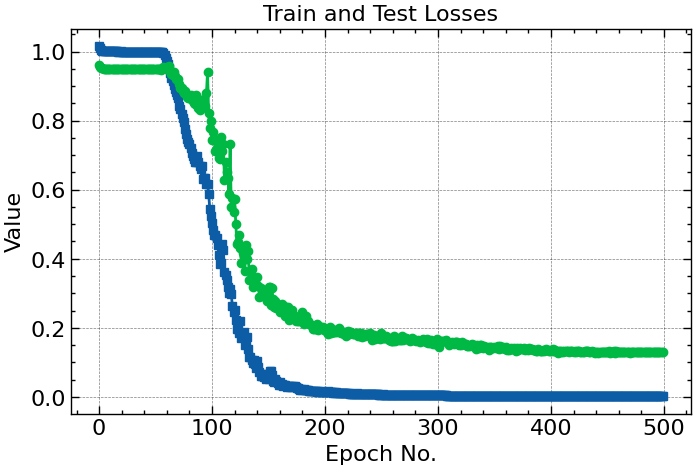

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/64_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015919
Avg Test loss: 0.960596 

Saving model...

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949797 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000047
Avg Test loss: 0.949990 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 1.000002
Avg Test loss: 0.949511 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.999998
Avg Test loss: 0.949566 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 1.000008
Avg Test loss: 0.949377 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.999995
Avg Test loss: 0.949107 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000050
Avg Test loss: 0.949504 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000043
Avg Test loss: 0.949306 

Epoch 28
-------------------------------
Cur

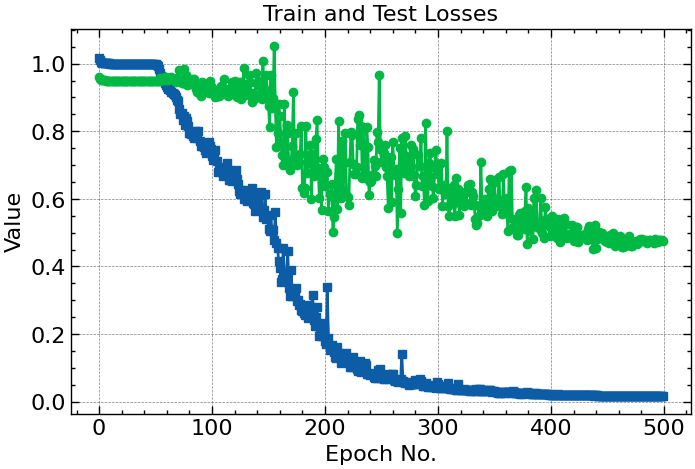

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/96_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015852
Avg Test loss: 0.960620 

Saving model...

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949908 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000058
Avg Test loss: 0.949967 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.999990
Avg Test loss: 0.949627 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 1.000002
Avg Test loss: 0.949789 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 1.000005
Avg Test loss: 0.949603 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.999990
Avg Test loss: 0.949571 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000069
Avg Test loss: 0.949775 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000019
Avg Test loss: 0.949368 

Epoch 28
-------------------------------
Cur

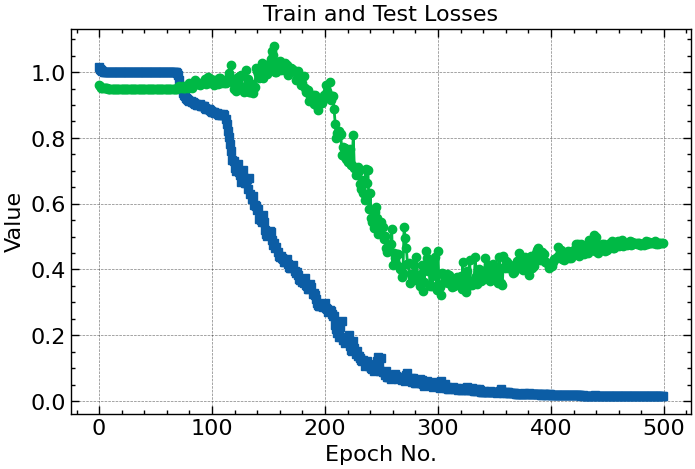

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/128_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015857
Avg Test loss: 0.960593 

Saving model..

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.950167 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000020
Avg Test loss: 0.950162 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 1.000011
Avg Test loss: 0.949763 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 1.000009
Avg Test loss: 0.949630 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.999990
Avg Test loss: 0.949557 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000051
Avg Test loss: 0.949368 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000053
Avg Test loss: 0.949687 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000004
Avg Test loss: 0.949431 

Epoch 28
-------------------------------
Cur

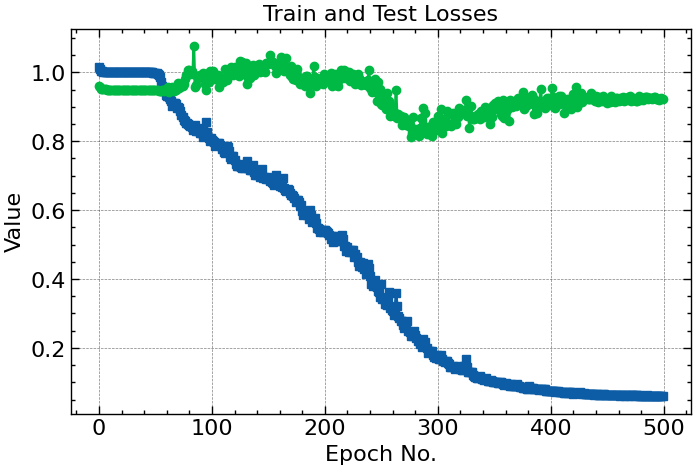

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/256_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015832
Avg Test loss: 0.960648 

Saving model..

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949947 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000083
Avg Test loss: 0.950073 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.999979
Avg Test loss: 0.949894 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.999987
Avg Test loss: 0.949729 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.999980
Avg Test loss: 0.949190 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000038
Avg Test loss: 0.949296 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000052
Avg Test loss: 0.949611 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000034
Avg Test loss: 0.949382 

Epoch 28
-------------------------------
Cur

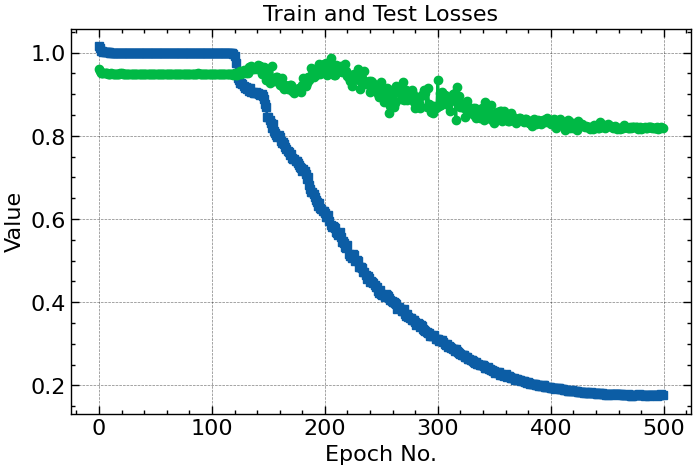

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/512_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015798
Avg Test loss: 0.960649 

Saving model..

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949846 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000044
Avg Test loss: 0.950150 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.999986
Avg Test loss: 0.949808 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 1.000010
Avg Test loss: 0.949870 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.999963
Avg Test loss: 0.949757 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000018
Avg Test loss: 0.949550 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000057
Avg Test loss: 0.949676 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.999998
Avg Test loss: 0.949471 

Epoch 28
-------------------------------
Cur

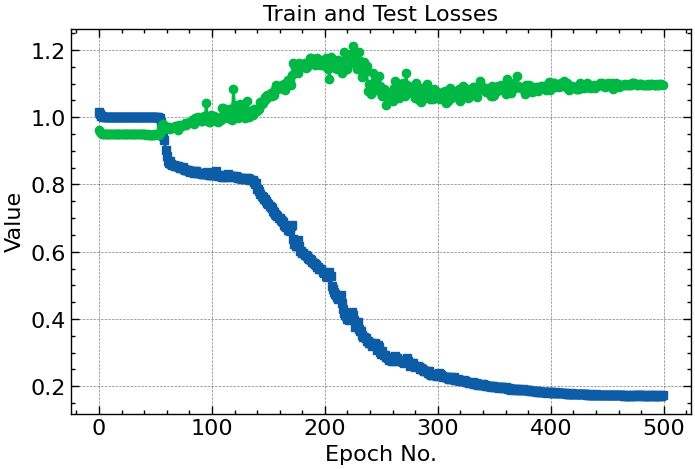

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/1024_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015809
Avg Test loss: 0.960724 

Saving model.

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.950209 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000056
Avg Test loss: 0.950290 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 1.000005
Avg Test loss: 0.949881 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 1.000010
Avg Test loss: 0.949877 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 1.000004
Avg Test loss: 0.949542 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000008
Avg Test loss: 0.949618 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000046
Avg Test loss: 0.949800 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000034
Avg Test loss: 0.949550 

Epoch 28
-------------------------------
Cur

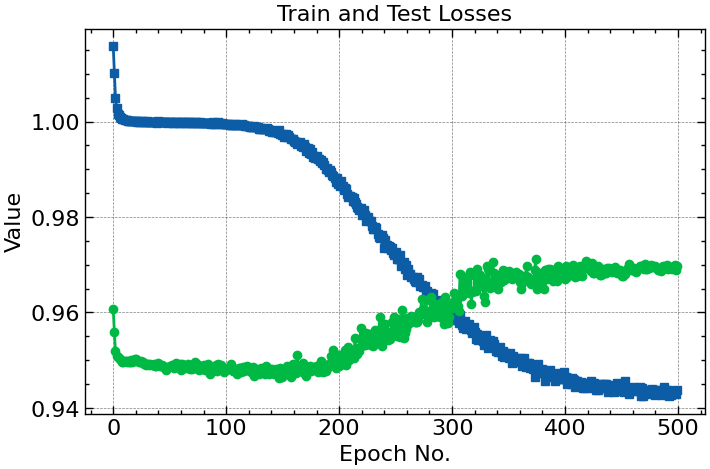

Minimum Loss: 0.12712467518035933


In [8]:
min_losses = []
for num_freqs in [32, 64, 96, 128, 256, 512, 1024]:
    min_losses.append(training_script(num_freqs))
print(f"Minimum Loss: {min(min_losses)}")

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/16_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015984
Avg Test loss: 0.960580 

Saving model...

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949760 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000062
Avg Test loss: 0.950027 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.999989
Avg Test loss: 0.949706 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.999991
Avg Test loss: 0.949297 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.999999
Avg Test loss: 0.949271 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000004
Avg Test loss: 0.949191 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000067
Avg Test loss: 0.949539 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.999975
Avg Test loss: 0.949114 

Epoch 28
-------------------------------
Cur

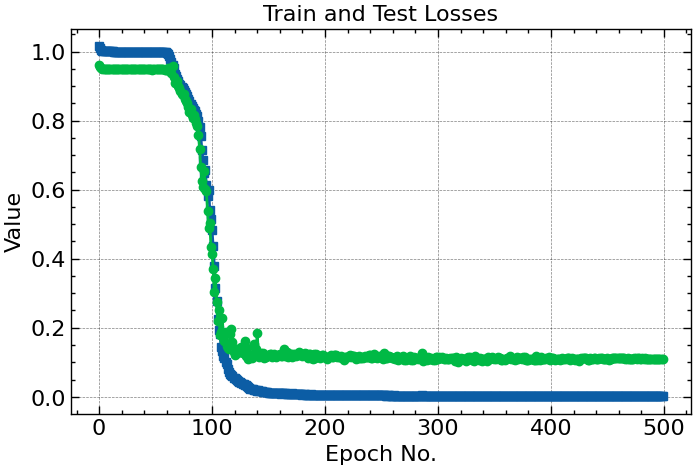

Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}
Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/48_test_index_0' created successfully.

Training dataset length: 467

Training dataset length: 1001

Test dataset length: 23

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.015789
Avg Test loss: 0.960737 

Saving model...

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.949723 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 1.000054
Avg Test loss: 0.949885 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 1.000017
Avg Test loss: 0.949532 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 1.000007
Avg Test loss: 0.949272 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.999989
Avg Test loss: 0.949066 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 1.000001
Avg Test loss: 0.948770 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 1.000039
Avg Test loss: 0.949289 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 1.000008
Avg Test loss: 0.949087 

Epoch 28
-------------------------------
Cur

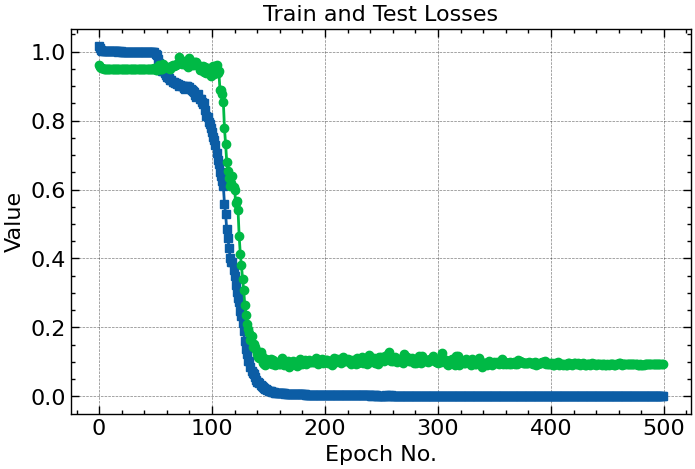

In [9]:
for num_freqs in [16, 48]:
    training_script(num_freqs)

In [ ]:
# to run many trials with a single frequency
for i in range(1, 100):
    training_script(48, index=i)

In [ ]:
# e.g. if you want to retrain from a checkpoint
training_script(32, index=14)

### Inference / Evaluation

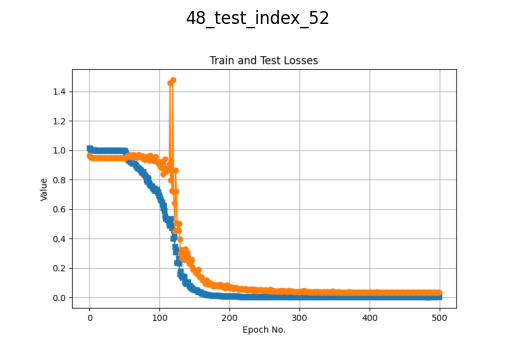

In [17]:
import re
import matplotlib.image as mpimg

# Root directory to start search (edit this if needed)
root_dir = "/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state"

# Regex to match folder names like "48_test_index_123"
pattern = re.compile(r"48_test_index_(\d+)")  # capture group added

allowed_li = [52]

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath)
    match = pattern.fullmatch(folder_name)
    if match:
        idx = int(match.group(1))
        if idx in allowed_li:
            img_path = os.path.join(dirpath, "train_test_losses.png")
            if os.path.isfile(img_path):
                img = mpimg.imread(img_path)
                plt.figure()
                plt.imshow(img)
                plt.axis("off")
                plt.title(folder_name)

plt.show()

In [4]:
def denormalize_channels(tensor, stats):
    num_indices = tensor.shape[-1]
    new_tensor = torch.zeros_like(tensor)
    for i in range(num_indices):
        new_tensor[..., i] = utils.denormalize(tensor[..., i], stats[f"elt_{i}"]["results"]["mean"], stats[f"elt_{i}"]["results"]["std_dev"])
    return new_tensor

In [5]:
def get_model_output(output_matrix, diag_idx, alpha):
    L = output_matrix.shape[0]
    # sanity check
    assert L == output_matrix.shape[1], "shapes don't match"

    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}/{label}.h5",
        "r",
    ) as f:
        OP_8x8 = f["OP_8x8"][()]
        print(OP_8x8.shape)
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)
    
    # first make sure they have the same pattern
    assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.4, (
        "Sorry, patterns do not match"
    )

    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][:, :, alpha, alpha]
    # diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][:, :, alpha, alpha]

    # determine which type of B.C.'s to apply
    clipped_OP_8x8 = diagonal_matrix_8x8[1:, 1:]
    if (check_D4_symmetries(clipped_OP_8x8)["reflection_anti_diag"] is True):
        mode = "adjacent"
    else:
        mode = "opposite"
    print(f"Selected mode: {mode}")

    # preprocess the diagonal matrices
    diag_matrix_8x8_np = apply_periodic_boundary_conditions(diagonal_matrix_8x8, mode=mode).numpy()
    # diag_matrix_18x18_np = apply_periodic_boundary_conditions(diagonal_matrix_18x18, mode=mode).numpy()

    # get symmetries
    symmetries_8x8 = check_D4_symmetries(diag_matrix_8x8_np)

    # symmetrize the model output
    output_matrix = apply_periodic_boundary_conditions(output_matrix, mode=mode)
    output_np = enforce_D4_symmetries_pytorch(output_matrix, symmetries_8x8).numpy()
    # print_comparison(diag_matrix_18x18_np, output_18x18_np)

    return output_np[:L, :L]

**Make diagonal_coords**

In [6]:
def get_V_coords(L):
    V = np.zeros((L, L, 2))
    for k_1 in range(L):
        for k_2 in range(L):
            V[k_1, k_2] = np.array([k_1 / L, k_2 / L])
    return V

V_8x8 = get_V_coords(8)

print(V_8x8[:, :, 0])

[[0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25 ]
 [0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375]
 [0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ]
 [0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625]
 [0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75 ]
 [0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875]]


In [7]:
print(V_8x8.reshape((64, 2)).shape)

(64, 2)


In [8]:
for L in range(8, 31, 2):  # and more
    coords = get_V_coords(L)
    coords = coords.reshape((L**2, 2))
    coords = torch.from_numpy(coords).float()
    torch.save(coords, f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{L}x{L}.pt")
    print(coords.shape, coords.dtype)

torch.Size([64, 2]) torch.float32
torch.Size([100, 2]) torch.float32
torch.Size([144, 2]) torch.float32
torch.Size([196, 2]) torch.float32
torch.Size([256, 2]) torch.float32
torch.Size([324, 2]) torch.float32
torch.Size([400, 2]) torch.float32
torch.Size([484, 2]) torch.float32
torch.Size([576, 2]) torch.float32
torch.Size([676, 2]) torch.float32
torch.Size([784, 2]) torch.float32
torch.Size([900, 2]) torch.float32


**More Postprocessing Code**

In [6]:
def main_function(num_freqs, dim, test_index=0, epoch=None):
    NUM_FREQS = num_freqs

    # directory for model + normalization constants
    folder_name = f"old_NN_{label}"
    directory = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/{folder_name}/"

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # get the filenames
    dims = list(range(8, 31, 2))    # should go from 8 to 30 in increments of 2
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    # load model (make sure matches what's in the folder)
    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = 4,
        embed_dim = 64,
        output_dim = 4,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    # Load the saved state_dict
    if epoch is None:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth"
    else:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{epoch}.pth"

    print(f"Loading model from {model_filename}")
    state_dict = torch.load(model_filename, map_location=device)

    # Create a new state_dict without the prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            name = k[10:] # remove `_orig_mod.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v

    # Load the corrected state_dict
    model.load_state_dict(new_state_dict)


    # get number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")

    # load normalization constants from file
    with open(directory + "normalization_constants.json", "r") as f:
        stats = json.load(f)

    print("Normalization Constants:")
    print(stats)

    # load dataset
    eval_dataset = utils.HF_3x3_Dataset(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/{error_c}/hubbard_model_lowest_energy_{dim}x{dim}_{label}.h5", stats)
    print(f"\nDataset size: {eval_dataset.__len__()}")

    # make a new DataLoader for testing purposes
    eval_dataloader = DataLoader(
        eval_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=1
    )

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    num_batches = len(eval_dataloader)
    test_loss = 0
    loss_fn = torch.nn.MSELoss()
    results_list = []


    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in eval_dataloader:
            # Move data to the appropriate device (CPU/GPU)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # convert to correct format
            pred = denormalize_channels(pred, stats)
            pred = pred.cpu().numpy()
            results_list.append(pred)
    
    results_list = np.concatenate(results_list, axis=0)
    # results_list should now be of shape (num_samples, L^2, 4)

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    
    with h5py.File(f"{directory}/output/test_{dim}x{dim}_num_freqs_{NUM_FREQS}.h5", "w") as f:
        for i in range(results_list.shape[0]):
            OP_tensor = results_list[i]
            count = 0
            diag_list = []
            for diag_idx in (0, 1):
                diag_tensor = np.zeros((dim, dim, 2, 2))
                for alpha in (0, 1):
                    diag_tensor[:, :, alpha, alpha] = get_model_output(OP_tensor[:, count].reshape(dim, dim), diag_idx, alpha)
                    count += 1
                diag_list.append(diag_tensor)
            
            folded_OP_mat = reformat_matrix_from_diagonals(diag_list)

            OP_mat = unfold_OP_mat(folded_OP_mat)
            OP_mat = np.transpose(OP_mat)
            OP_mat = np.array([OP_mat.real, OP_mat.imag])
            f.create_dataset(f"ML_{i+1}", data=OP_mat)

    return results_list

In [7]:
# generate outputs
for L in range(12, 31, 2):
    main_function(num_freqs=48, dim=L, test_index=52, epoch=3201)

Using device: cuda
Loading model from /blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_ground_state/48_test_index_52/hubbard_model_2BPV_HF_model_num_freqs_48_epoch_3201.pth
Number of trainable parameters: 102172
Normalization Constants:
{'elt_0': {'initial': {'mean': 1.0004087686538696, 'std_dev': 0.5771366953849792}, 'results': {'mean': 0.5, 'std_dev': 0.42605844140052795}}, 'elt_1': {'initial': {'mean': 1.000795602798462, 'std_dev': 0.5777232646942139}, 'results': {'mean': 0.5, 'std_dev': 0.4260615110397339}}, 'elt_2': {'initial': {'mean': 0.9311677813529968, 'std_dev': 0.4036557078361511}, 'results': {'mean': -0.20586493611335754, 'std_dev': 0.16154003143310547}}, 'elt_3': {'initial': {'mean': 1.0584516525268555, 'std_dev': 0.4056928753852844}, 'results': {'mean': 0.20585721731185913, 'std_dev': 0.16154178977012634}}}

Dataset size: 11
Test loss: 0.006534 

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : Y

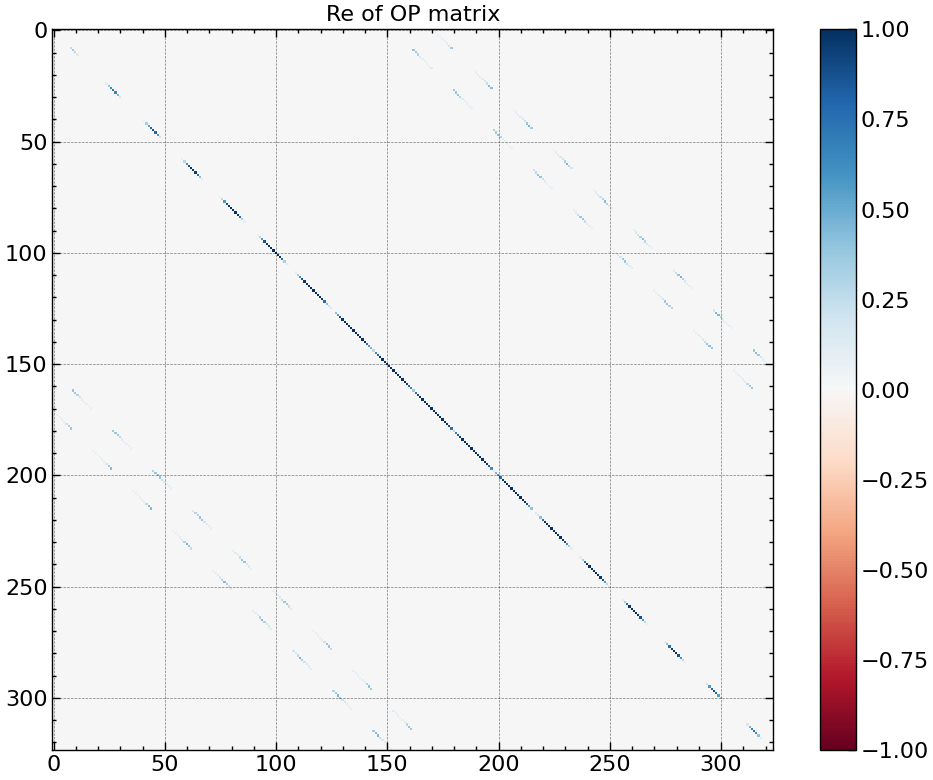

In [ ]:
# check outputs
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_excited_state/old_NN_18x18_U_1_excited_state_num_freqs_32_test1.h5", 'r') as f:
    OP_mat = np.transpose(f['ML_1'][()])
    OP_mat = OP_mat[:, :, 0] + (1j * OP_mat[:, :, 1])
    plot_complex_matrix(fold_OP_mat(OP_mat)[:, :, 0, 0])

In [13]:
with h5py.File(
        "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_excited_state/U_1_excited_state.h5",
        "r",
    ) as f:
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)

print_comparison(OP_mat, OP_18x18)

(648, 648)
Max diff: 0.3028670763965917
MSE: 1.992305568379723e-05


(np.float64(0.3028670763965917), np.float64(1.992305568379723e-05))